# Nexus usage example

## Install and Load packages

In [1]:
# Install and load Harbinger, Nexus and DalEvents -----------------------------
#devtools::install_github("cefet-rj-dal/daltoolbox", force=TRUE, dependencies=FALSE, upgrade="never", build_vignettes = TRUE)
#devtools::install_github("cefet-rj-dal/harbinger", force=TRUE, dependencies=FALSE, upgrade="never", build_vignettes = TRUE)
#devtools::install_github("cefet-rj-dal/event_datasets", force = TRUE, dep=FALSE, upgrade="never")

# Load packages
library(daltoolbox)
library(harbinger)
source("https://raw.githubusercontent.com/cefet-rj-dal/harbingerext/main/develop/nexus.R")
library(dalevents)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘daltoolbox’


The following object is masked from ‘package:base’:

    transform




## Load dataset

The object data represent both Nexus classes *Time Series* and *Events Reference*
* "series" refers to the time series values on class *Time Series*
* "event" refers to the event labels on class *Events Reference*
* the line index refers to the position of the analyzed point connecting both classes

In [2]:
#Select desired series and time interval

#ph variable
#Interval of a day with anomalies
data(gecco)
data <- subset(gecco$gecco[16500:18000,], select = c(ph, event))

#Adjust variables names
  #"series" refers to the time series values
  #"event" refers to the event labels
  #the line index refers to the position of the analyzed point
names(data) <- c("series", "event")

In [3]:
#First lines of data
head(data)

,series,event
,<dbl>,<int>
16500,8.37,0
16501,8.38,0
16502,8.38,0
16503,8.37,0
16504,8.38,0
16505,8.38,0


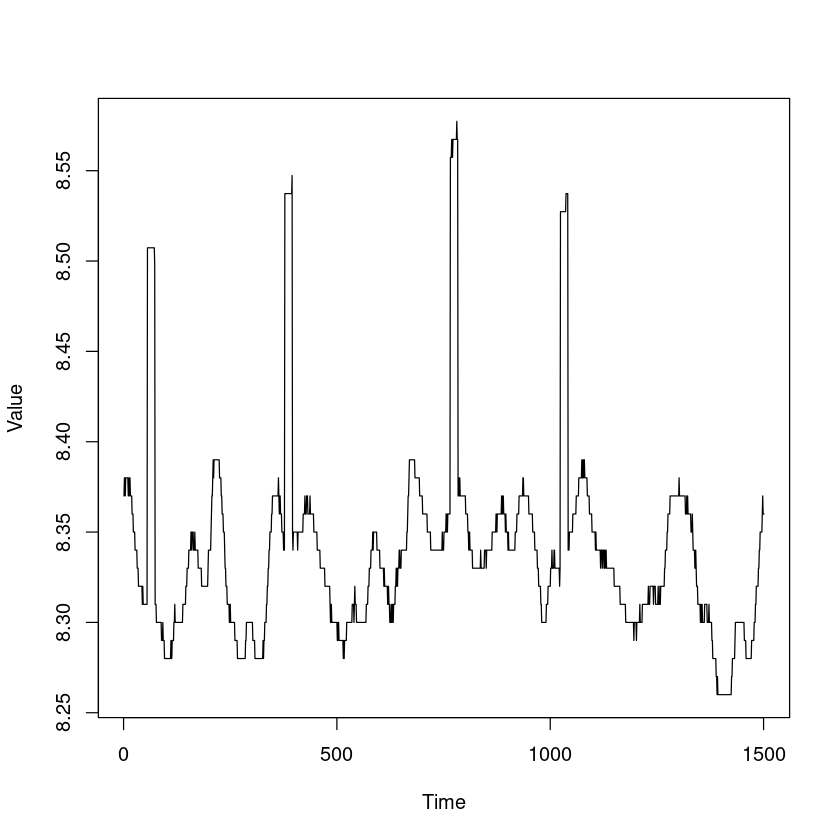

In [4]:
plot(as.ts(data$series),
    xlab = "Time",
    ylab = "Value")

In [5]:
#First line with real events
head(data[data$event == 1,])

,series,event
,<dbl>,<int>
16555,8.507335,1
16556,8.507335,1
16557,8.507335,1
16558,8.507335,1
16559,8.507335,1
16560,8.507335,1


## Nexus

### Establishing method

The model contains an object of the classes *Anomaly Detector* or *Change Point Detector*. To create the object, the usage examples at https://nbviewer.org/github/cefet-rj-dal/harbinger-examples/tree/main/ must be followed.

Since the detectors are created below without parameters, both the *detection_params* and *model_params* attributes use the default values of each method.

In [6]:
#Models of anomaly detector and change ponint detector
model <- hanr_fbiad() #FBI-AD (Anomaly Detector)
#model <- hcp_cf_lr() #CF using Linear Regression (Change Point Detector)

### Run Experiments

The values ​​of each vector in the next cell represent the Nexus parameter options.
* *bt_size*: $s \rightarrow$ batch size
* *wm_size*: $w \rightarrow$ warmup size
* *mem_bt*: $m \rightarrow$ memory options$^{(1)}$

(1): $m=0 \rightarrow$ Full memory; $m=n>0 \rightarrow$ Partial memory with memory equal to $n$ batches

In [7]:
#Create and setup objects
bt_size <- c(1,3,9,27,81) #Options of batch sizes
wm_size <- c(1,3,9,27,81) #Options of warmup sizes
mem_bt <- c(0,3,9) #Options of memory

The next cell executes the *stream_detect* method of the class *Stream Runner* and records the output with the classes *Stream Detections* and *Stream Results* in the R variable *result*.

In [8]:
#Choose the model in cell 6 before running the experiment
result <- run_nexus(model=model, data=data, warm_size=wm_size[5], batch_size=bt_size[5], mem_batches=mem_bt[1])

[1] "Starting streaming analysis..."
[1] "Nexus run complete."


### Stream Detections

In [9]:
# View Stream Detections --------------------------------------------------
head(result$detection, 20)

,idx,event,type
,<dbl>,<int>,<chr>
1,1,0,
2,2,0,
3,3,0,
4,4,0,
5,5,0,
6,6,0,
7,7,0,
8,8,0,
9,9,0,


### Stream Results

$P(E_i)$

In [10]:
#Event Probability
head(result$prob)

,idx,fdb,ef,bf,pe
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15,17,2,19,0.1052632
2,35,7,12,19,0.6315789
3,36,2,17,19,0.8947368
4,37,2,17,19,0.8947368
5,38,2,17,19,0.8947368
6,39,2,17,19,0.8947368


$Lag_t$

$t=36$

In [11]:
#Detection lag to t=36
lag_evaluate(pos=36, nexus_result=result, reference = data$event)

idx,fdb,sb,lag,batch_size,method
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
36,2,1,1,81,hanr_fbiad


### Detections Metrics

In [12]:
# evaluating the detections

evaluation <- evaluate(result$detector,
                       result$detection$event,
                       data$event)
#Confusion matrix
print(evaluation$confMatrix)

          event      
detection TRUE  FALSE
TRUE      72    285  
FALSE     0     1144 


In [13]:
#Metrics Example
evaluation$accuracy

[1] 0.8101266

In [14]:
evaluation$F1

[1] 0.3356643

### Visual Analysis

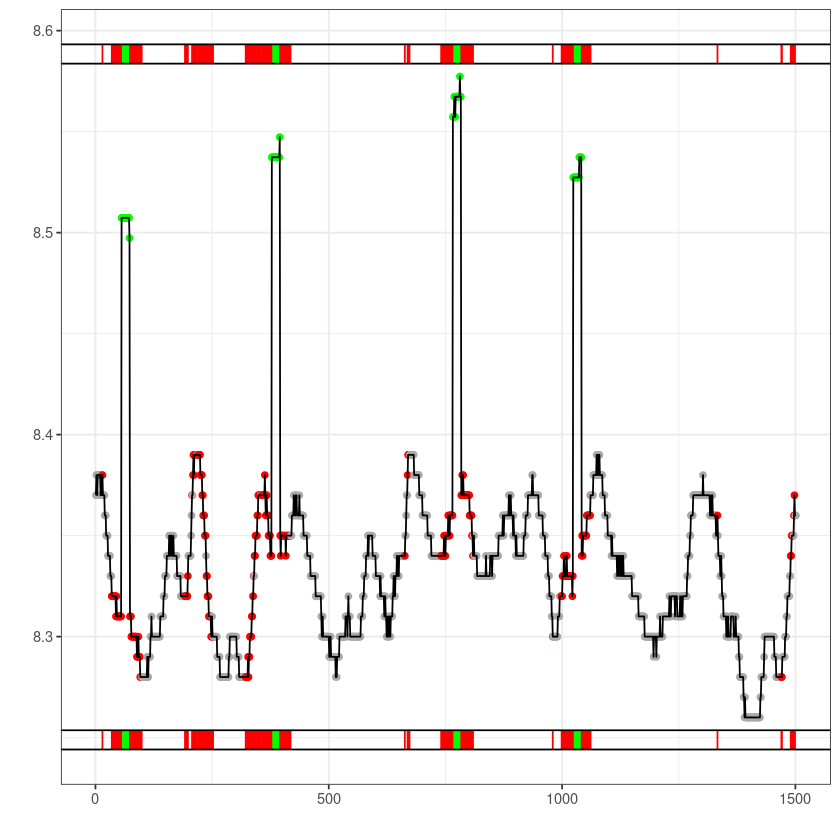

In [15]:
# plotting the results
grf <- har_plot(result$detector, data$series, result$detection, data$event)
plot(grf)

### Probability comparison

Filter only events detected with $P(E_i) > plim$

$plim =$ limite de probabilidade desejada.

In [16]:
#Recover probabilites from Stream Results
prob <- result$prob

#Filter by limit
plim = 0.8
prob_lim <- subset(prob, pe > plim)

In [17]:
det_prob <- result$detection
det_prob$event <- 0
det_prob$event[which(det_prob$idx %in% prob_lim$idx)] <- 1

In [18]:
#Events with P(e) > plim
head(det_prob)

,idx,event,type
,<dbl>,<dbl>,<chr>
1,1,0,
2,2,0,
3,3,0,
4,4,0,
5,5,0,
6,6,0,


In [19]:
#Sum of events
#Without filter
sum(result$detection$event)

[1] 357

In [20]:
#With plim filter
sum(det_prob$event)

[1] 266

In [21]:
#Evaluate limit query detection
print(evaluate(result$detector, det_prob$event, data$event)$confMatrix)

          event      
detection TRUE  FALSE
TRUE      72    194  
FALSE     0     1235 


### Execution time analysis 

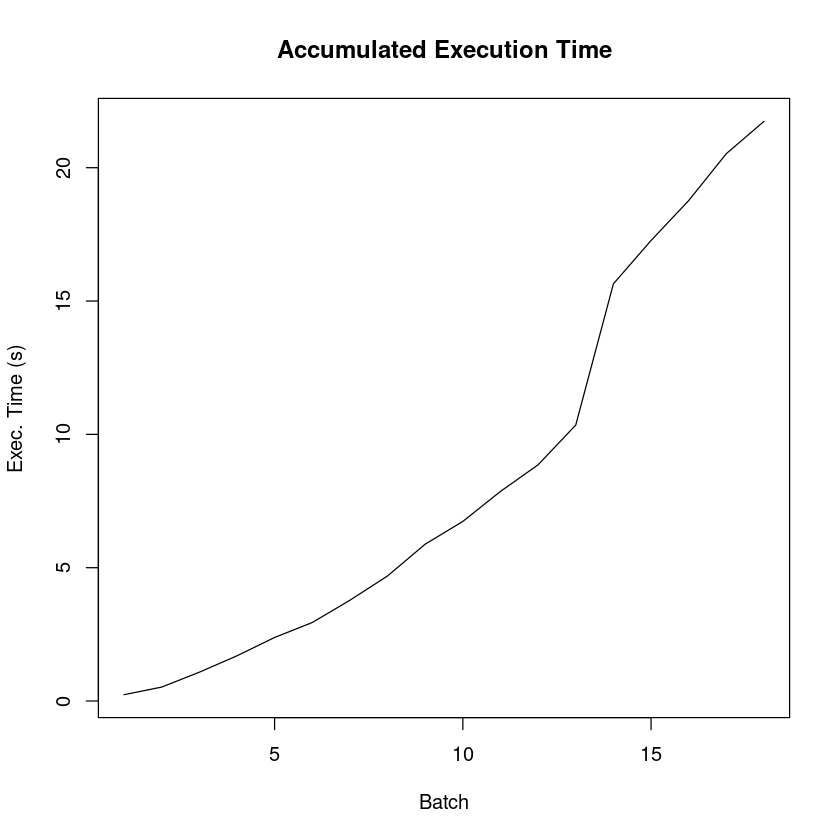

In [22]:
#Accumulated Execution Time
plot(result$time,
     xlab = "Batch",
     ylab = "Exec. Time (s)",
     type = "l",
     main = "Accumulated Execution Time")

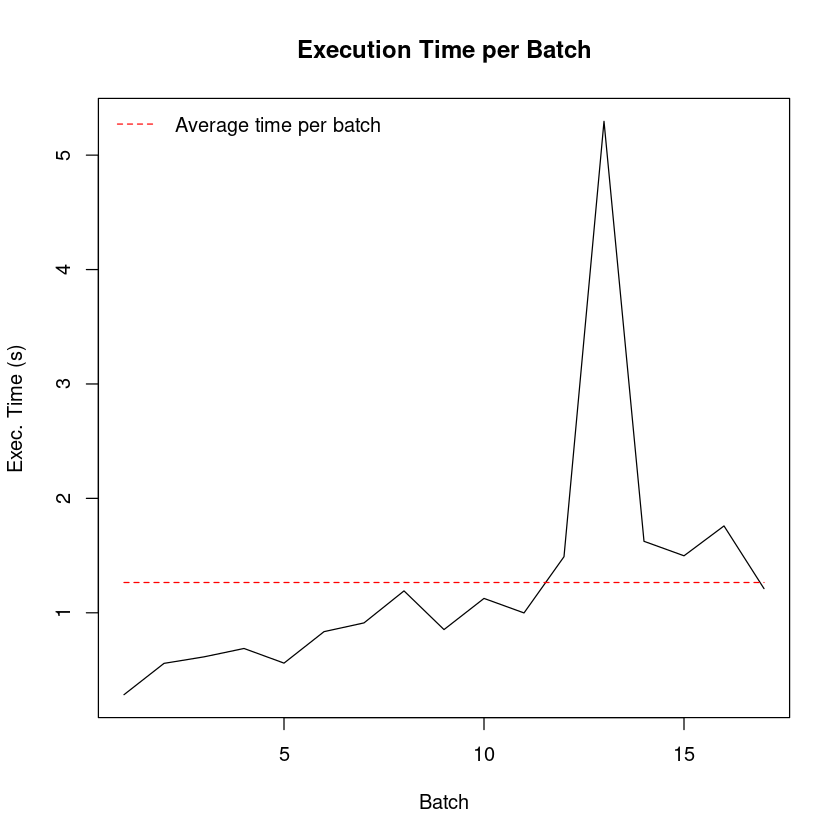

In [23]:
#Execution Time per Batch
time_per_batch <- diff(result$time)

plot(time_per_batch,
     xlab = "Batch",
     ylab = "Exec. Time (s)",
     type = "l",
     main = "Execution Time per Batch")

lines(x = 1:length(time_per_batch), y = rep(mean(time_per_batch), length(time_per_batch)),
      lty = 2, #Tipo de linha
      lwd = 1, #Tipo de linha
      col="red")

#Adição de legendas
legend(x = "topleft",                 #Posição da legenda
       legend = "Average time per batch",   #Legenda
       lty = 2, lwd = 1,              #Configurações do símbolo (neste caso linha)
       bty = "n",                     #Caixa ao redor da legenda "n" = nenhuma
       col="red")